# ARIMA Models to Impute Missing Data
Univariate approach to fill in gaps in the data.

Some resources:
* [Short and Sweet Explanation with a Similarly Short Example](https://towardsdatascience.com/understanding-arima-time-series-modeling-d99cd11be3f8)

In [63]:
import pandas as pd
import numpy as np

from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime

import sys
sys.path.append('../')

from src.visualization import visualize
from src.processing import impute

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Getting the Data

In [2]:
def plot_ts(df,species):
    """
    Plots the data
    """
    _, ax = plt.subplots(figsize=(24,4))
    ax.plot(df.index,df[species],lw=2,color="black")
    
    for loc in ["top","right"]:
        ax.spines[loc].set_visible(False)

    plt.show()
    plt.close()

## Complete Dataset

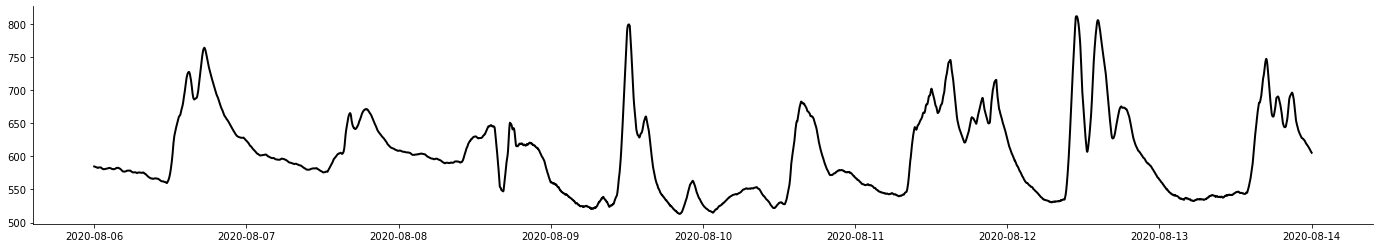

In [23]:
data = pd.read_csv("../data/interim/imputation/beacon-example-rnse61g4-ux_s20.csv",index_col=0,parse_dates=["timestamp"],infer_datetime_format=True)
data = data[datetime(2020,8,6):datetime(2020,8,14)].asfreq(freq='2T')
plot_ts(data,"co2")

## Missing at Random

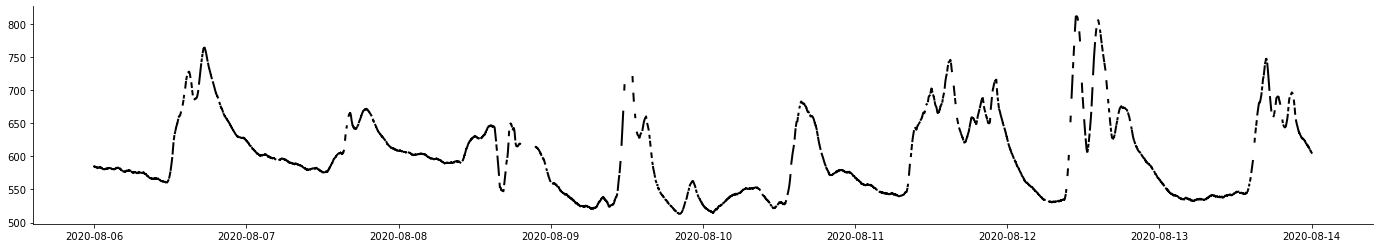

In [4]:
miss_rand = pd.read_csv("../data/interim/imputation/missing_data-co2-random-p30-rnse61g4.csv",index_col=0,parse_dates=["timestamp"],infer_datetime_format=True)
miss_rand.set_index("timestamp",inplace=True)
miss_rand = miss_rand[datetime(2020,8,6):datetime(2020,8,14)].asfreq(freq='2T')
plot_ts(miss_rand,"co2")

## Missing in Periods

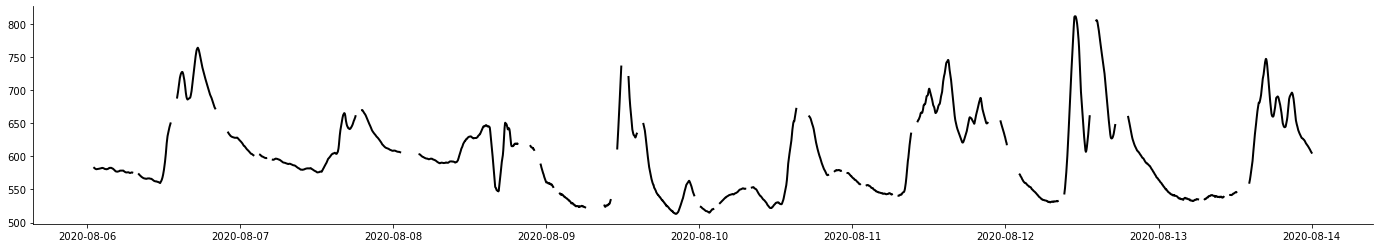

In [5]:
miss_periods = pd.read_csv("../data/interim/imputation/missing_data-random_periods-co2-p20-60mins-rnse61g4.csv",index_col=0,parse_dates=["timestamp"],infer_datetime_format=True)
miss_periods = miss_periods[datetime(2020,8,6):datetime(2020,8,14)].asfreq(freq='2T')
plot_ts(miss_periods,"co2")

# ARIMA Modeling

In [68]:
def run_arima(df,var="co2",order=(1,1,1),freq="2T"):
    """
    Runs the ARIMA model
    """
    mod = ARIMA(df["co2"], order=order, freq=freq)
    predictions = mod.fit().predict()
    res = pd.DataFrame(data=predictions)
    res.columns = [var]
    res.replace(0,np.nanmean(res[var]),inplace=True)
    plot_predictions(df,res,var)
    return res
    #return res.set_index("timestamp")

In [69]:
def plot_predictions(df,y_pred,var="co2"):
    """
    Plots the predictions against the true values
    """
    
    _, ax = plt.subplots(figsize=(24,4))
    ax.plot(df.index,df[var],lw=2,color="black",label="Actual")
    temp = df.copy()
    temp["pred"] = y_pred
    ax.plot(temp.index,temp["pred"],lw=2,color="goldenrod")
    
    for loc in ["top","right"]:
        ax.spines[loc].set_visible(False)
    
    plt.show()
    plt.close()

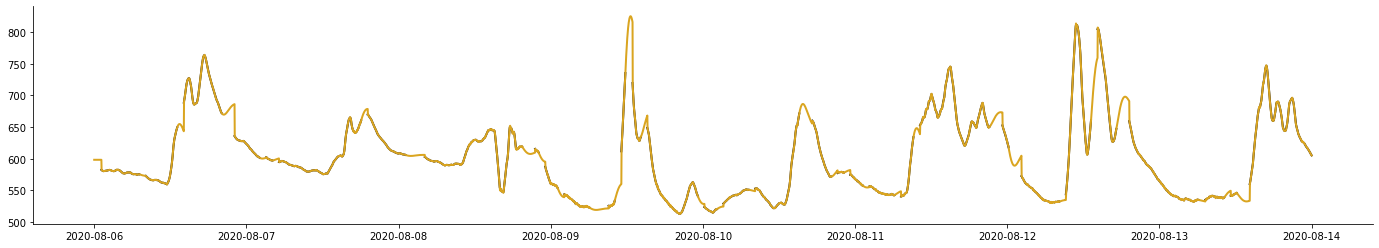

In [70]:
y_pred = run_arima(miss_periods,"co2",order=(2,1,2))

In [71]:
imp = impute.Impute(pt="rnse61g4",data_dir="../",prompt=False)
imp.set_base(data)
imp.set_param("co2")

In [72]:
imp.evaluate(y_pred)

(0.9859915138588623, 2.1793629363877076, 7.185377988218855, 0.996522710840598)